# Forecasting IHSG dengan MLP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
import warnings
warnings.filterwarnings('ignore')

# Set seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## Data Loading

In [2]:
import pandas as pd

# Baca file Excel IHSG
df = pd.read_excel('../data/IHSG_data_1.xlsx')

df['Price'] = pd.to_datetime(df['Price'])
df = df[df['Price'] >= '2024-01-01'].reset_index(drop=True)

# Tampilkan 5 baris pertama
print(f"Data setelah dipotong: {len(df)} entries")
print(f"Periode: {df['Price'].min()} hingga {df['Price'].max()}")
print()
print(df.head())

Data setelah dipotong: 438 entries
Periode: 2024-01-02 00:00:00 hingga 2025-11-07 00:00:00

       Price        Close         High          Low         Open     Volume
0 2024-01-02  7323.587891  7323.587891  7245.565918  7268.397949  121359000
1 2024-01-03  7279.090820  7321.878906  7275.874023  7316.108887  159498400
2 2024-01-04  7359.763184  7371.234863  7280.407227  7290.064941  155674900
3 2024-01-05  7350.619141  7403.578125  7350.619141  7376.288086  163057200
4 2024-01-08  7283.575195  7393.131836  7275.170898  7362.046875  140602400


## Data Preparation

In [3]:
# Persiapan data
df = df.sort_values('Price')
df.reset_index(drop=True, inplace=True)

print("Shape data:", df.shape)
print("\nInfo data:")
print(df.info())
print("\nStatistik deskriptif:")
print(df.describe())

Shape data: (438, 6)

Info data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Price   438 non-null    datetime64[ns]
 1   Close   438 non-null    float64       
 2   High    438 non-null    float64       
 3   Low     438 non-null    float64       
 4   Open    438 non-null    float64       
 5   Volume  438 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 20.7 KB
None

Statistik deskriptif:
                               Price        Close         High          Low  \
count                            438   438.000000   438.000000   438.000000   
mean   2024-12-07 22:41:05.753424640  7286.765859  7333.007685  7244.451195   
min              2024-01-02 00:00:00  5967.987793  6036.554199  5882.604980   
25%              2024-06-28 18:00:00  7070.142578  7117.355225  7031.065918   
50%              2

## Feature Engineering

In [4]:
# Buat features
print("\nMenggunakan hanya variabel 'Close'...")

# Gunakan 'Close' sebagai input dan target untuk forecasting satu langkah ke depan
X = df['Close'][:-1].values.reshape(-1, 1)  # Semua kecuali yang terakhir
y = df['Close'][1:].values  # Semua kecuali yang pertama

print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")

# Split data: 70% training, 15% validation, 15% testing
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, shuffle=False)

print(f"\nData split:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")


Menggunakan hanya variabel 'Close'...
Shape X: (437, 1)
Shape y: (437,)

Data split:
Training: 305 samples
Validation: 66 samples
Testing: 66 samples


## Data Normalization

In [5]:
# Normalisasi data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

## Model Definition

In [6]:
# Model MLP yang Lebih Baik
def create_mlp_model(input_dim, optimizer):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.3),

        Dense(1)
    ])
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

## Optimizer Configuration

In [7]:
# Optimizers dengan tuned hyperparameters
optimizers_dict = {
    'Adam': Adam(learning_rate=0.001),
    'Nadam': Nadam(learning_rate=0.001),
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adadelta': Adadelta(learning_rate=1.0),
    'Adagrad': Adagrad(learning_rate=0.01),
    'SGD': SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    'Adamax': Adamax(learning_rate=0.002)
}

# Menyimpan hasil
results = {}
histories = {}
predictions = {}

## Model Training

In [8]:
print("\n" + "="*80)
print("TRAINING MODEL - IMPROVED VERSION")
print("="*80)

# Training untuk setiap optimizer
for opt_name, optimizer in optimizers_dict.items():
    print(f"\n{'='*80}")
    print(f"Training: {opt_name}")
    print(f"{'='*80}")
    
    # Reset seed
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Buat model
    model = create_mlp_model(X_train_scaled.shape[1], optimizer)
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=15,
            min_lr=1e-7,
            verbose=0
        )
    ]
    
    # Training
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=200,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    
    # Prediksi
    y_pred_scaled = model.predict(X_test_scaled, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    # Evaluasi
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100
    
    # Simpan hasil
    results[opt_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Epochs': len(history.history['loss'])
    }
    
    histories[opt_name] = history
    predictions[opt_name] = y_pred
    
    print(f"✓ Finished at epoch {len(history.history['loss'])}")
    print(f"  RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")

# Tampilkan hasil
print("\n" + "="*80)
print("HASIL PERBANDINGAN OPTIMIZER")
print("="*80)

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')
print("\n", results_df.to_string())


TRAINING MODEL - IMPROVED VERSION

Training: Adam
✓ Finished at epoch 71
  RMSE: 129.74 | MAE: 115.28 | R²: 0.6021 | MAPE: 1.43%

Training: Nadam
✓ Finished at epoch 87
  RMSE: 124.94 | MAE: 110.33 | R²: 0.6309 | MAPE: 1.38%

Training: RMSprop
✓ Finished at epoch 68
  RMSE: 110.30 | MAE: 95.62 | R²: 0.7124 | MAPE: 1.19%

Training: Adadelta
✓ Finished at epoch 71
  RMSE: 133.20 | MAE: 118.52 | R²: 0.5805 | MAPE: 1.47%

Training: Adagrad
✓ Finished at epoch 139
  RMSE: 283.87 | MAE: 271.10 | R²: -0.9051 | MAPE: 3.37%

Training: SGD
✓ Finished at epoch 79
  RMSE: 223.57 | MAE: 207.08 | R²: -0.1817 | MAPE: 2.57%

Training: Adamax
✓ Finished at epoch 83
  RMSE: 129.10 | MAE: 114.70 | R²: 0.6060 | MAPE: 1.43%

HASIL PERBANDINGAN OPTIMIZER

                    MSE        RMSE         MAE        R2      MAPE  Epochs
RMSprop   12165.624114  110.297888   95.624490  0.712376  1.189022    68.0
Nadam     15611.131949  124.944515  110.330885  0.630916  1.375177    87.0
Adamax    16666.404535  129.0

## Results Visualization

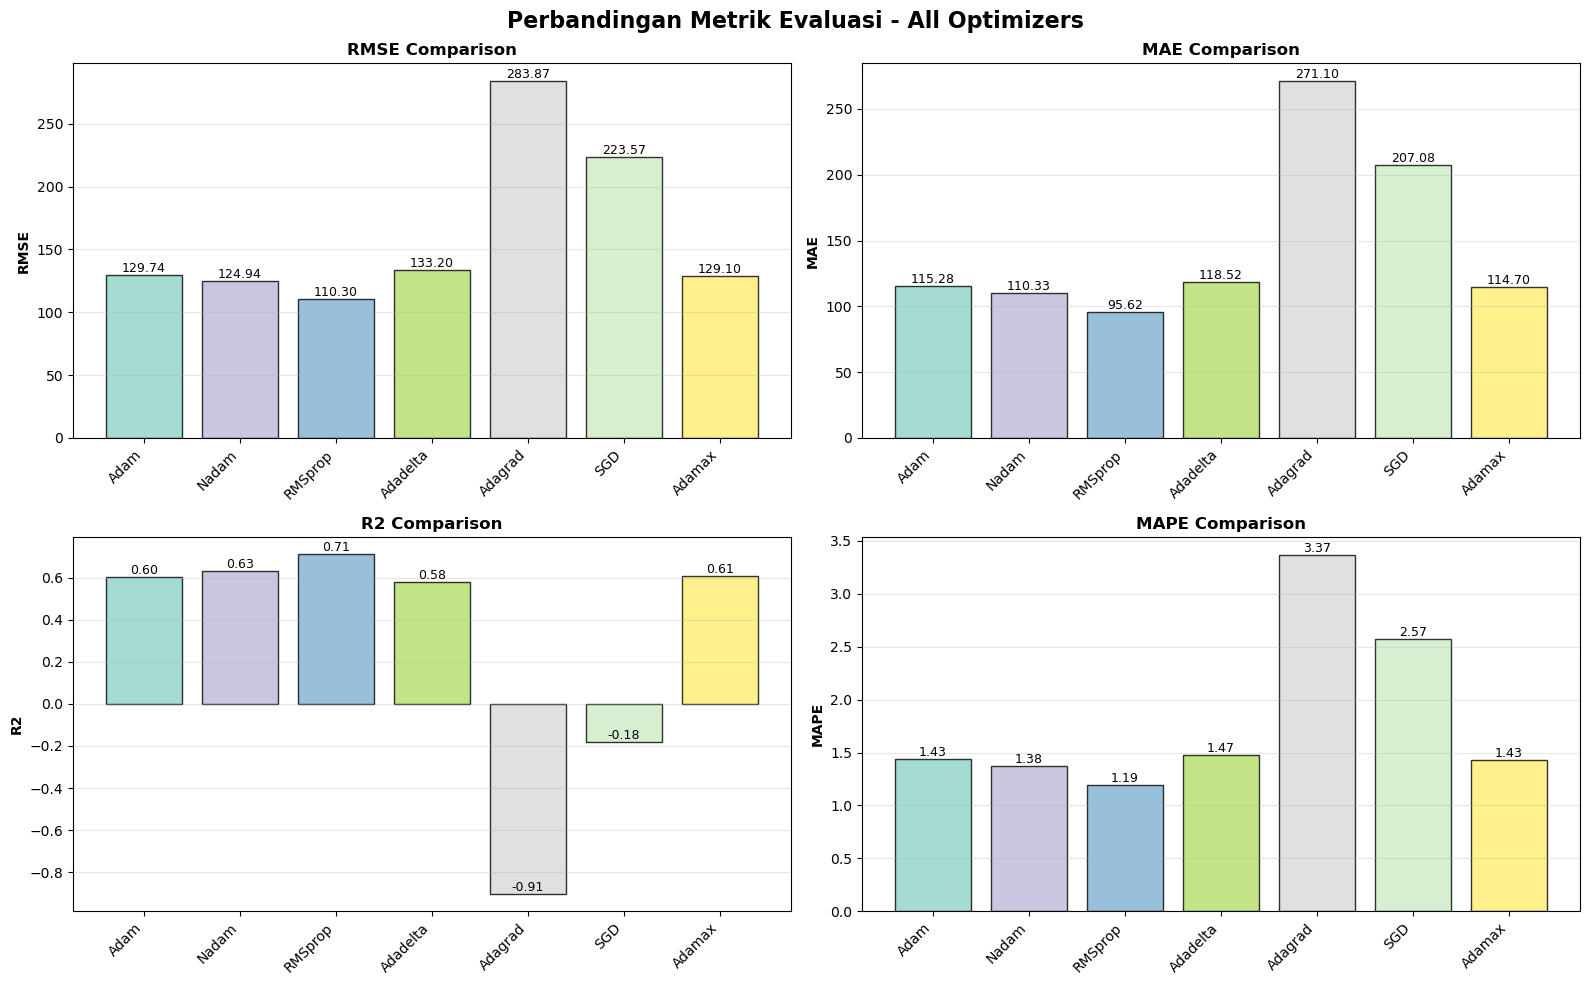

In [9]:
# Visualisasi 1: Bar Chart Perbandingan Metrik
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Perbandingan Metrik Evaluasi - All Optimizers', fontsize=16, fontweight='bold')

metrics = ['RMSE', 'MAE', 'R2', 'MAPE']
colors = plt.cm.Set3(np.linspace(0, 1, len(optimizers_dict)))

for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    values = [results[opt][metric] for opt in optimizers_dict.keys()]
    bars = ax.bar(range(len(optimizers_dict)), values, color=colors, edgecolor='black', alpha=0.8)
    ax.set_xticks(range(len(optimizers_dict)))
    ax.set_xticklabels(optimizers_dict.keys(), rotation=45, ha='right')
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Tambahkan nilai di atas bar
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

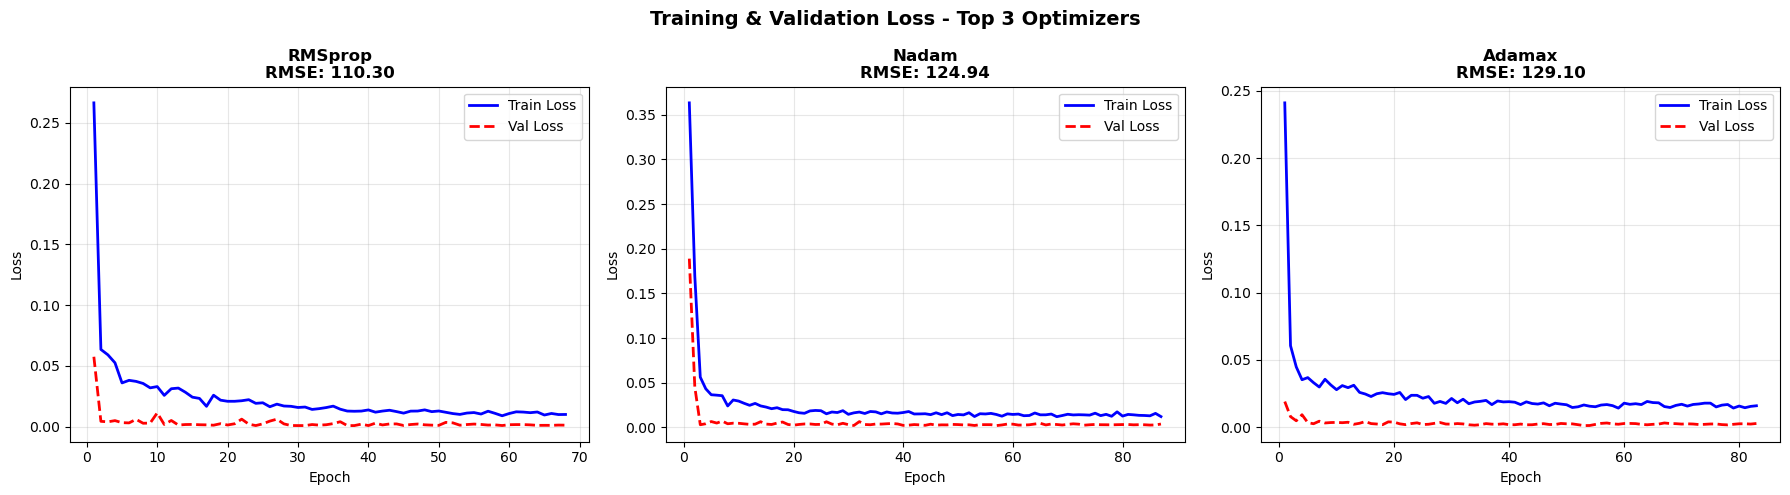

In [10]:
# Visualisasi 2: Training History Top 3
best_3 = results_df.head(3).index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training & Validation Loss - Top 3 Optimizers', fontsize=14, fontweight='bold')

for idx, opt_name in enumerate(best_3):
    ax = axes[idx]
    history = histories[opt_name]
    
    epochs = range(1, len(history.history['loss']) + 1)
    ax.plot(epochs, history.history['loss'], 'b-', label='Train Loss', linewidth=2)
    ax.plot(epochs, history.history['val_loss'], 'r--', label='Val Loss', linewidth=2)
    
    ax.set_title(f'{opt_name}\nRMSE: {results[opt_name]["RMSE"]:.2f}', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

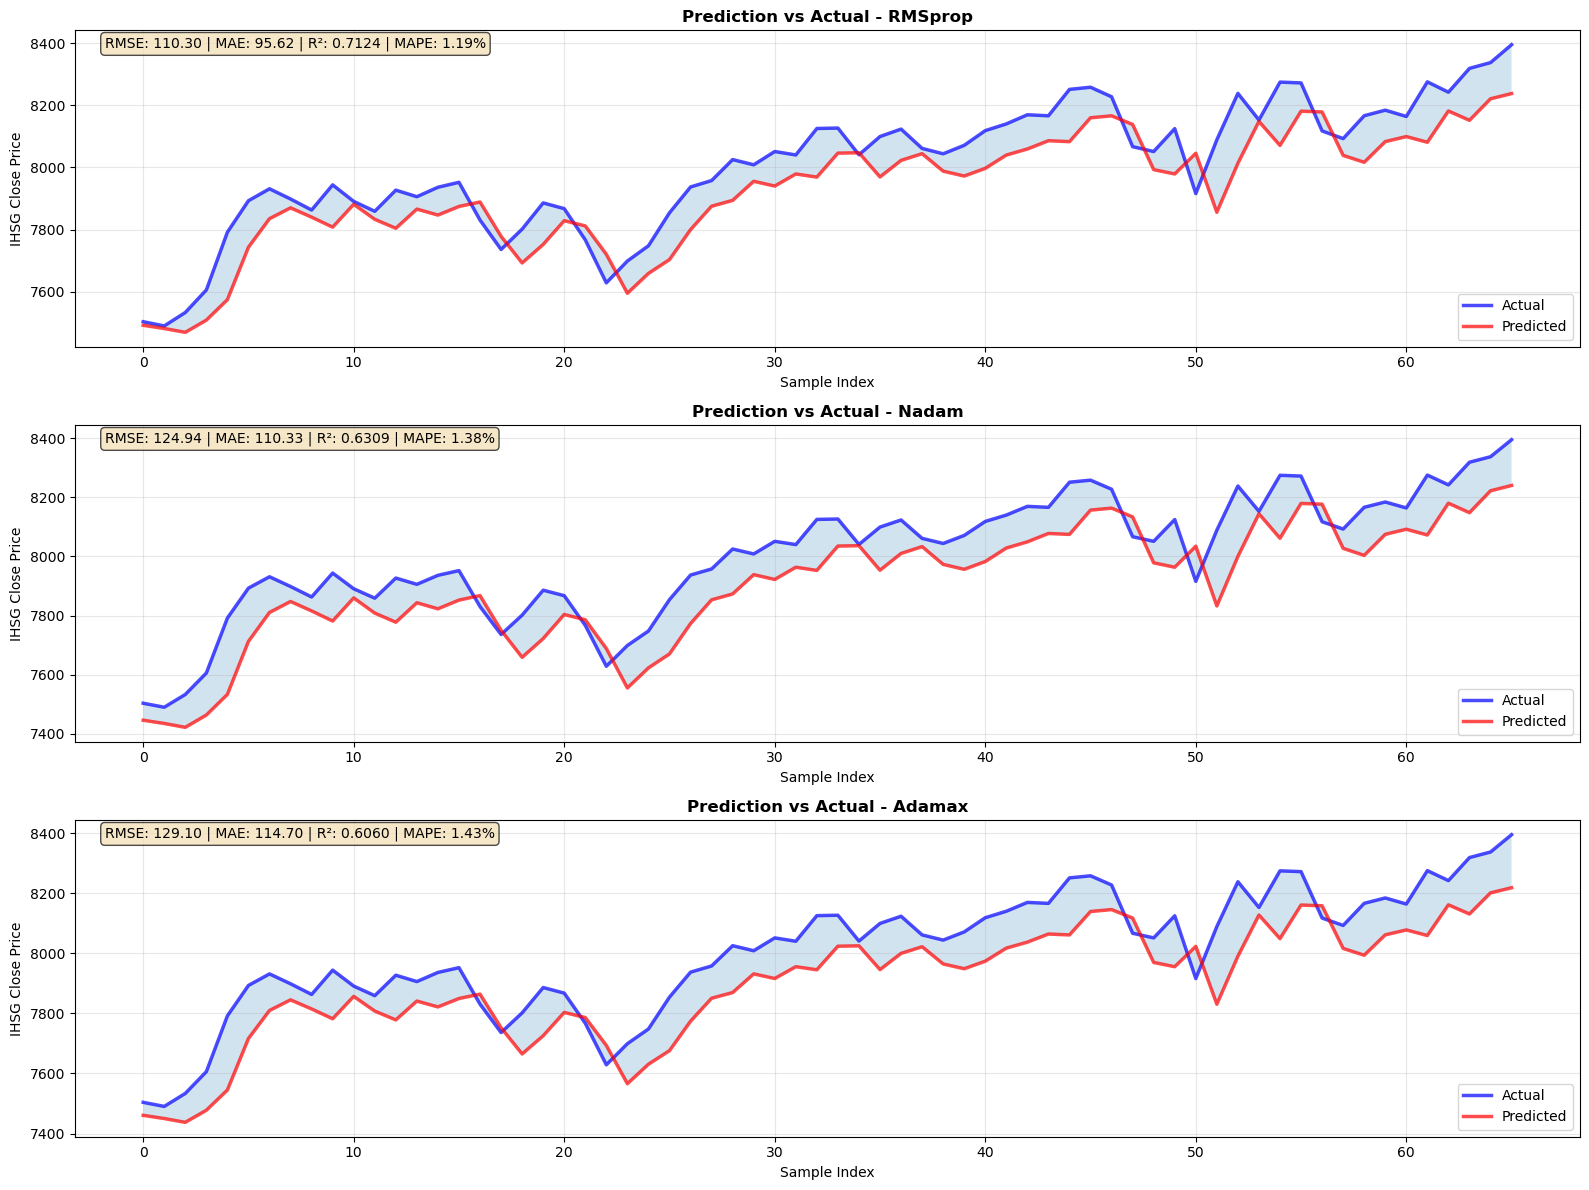

In [11]:
# Visualisasi 3: Prediksi vs Aktual untuk Top 3
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for idx, opt_name in enumerate(best_3):
    ax = axes[idx]
    y_pred = predictions[opt_name]
    
    x_axis = range(len(y_test))
    ax.plot(x_axis, y_test, label='Actual', color='blue', linewidth=2.5, alpha=0.7)
    ax.plot(x_axis, y_pred, label='Predicted', color='red', linewidth=2.5, alpha=0.7)
    ax.fill_between(x_axis, y_test, y_pred.flatten(), alpha=0.2)
    
    # Add metrics
    metrics_text = (f"RMSE: {results[opt_name]['RMSE']:.2f} | "
                   f"MAE: {results[opt_name]['MAE']:.2f} | "
                   f"R²: {results[opt_name]['R2']:.4f} | "
                   f"MAPE: {results[opt_name]['MAPE']:.2f}%")
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    ax.set_title(f'Prediction vs Actual - {opt_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('IHSG Close Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

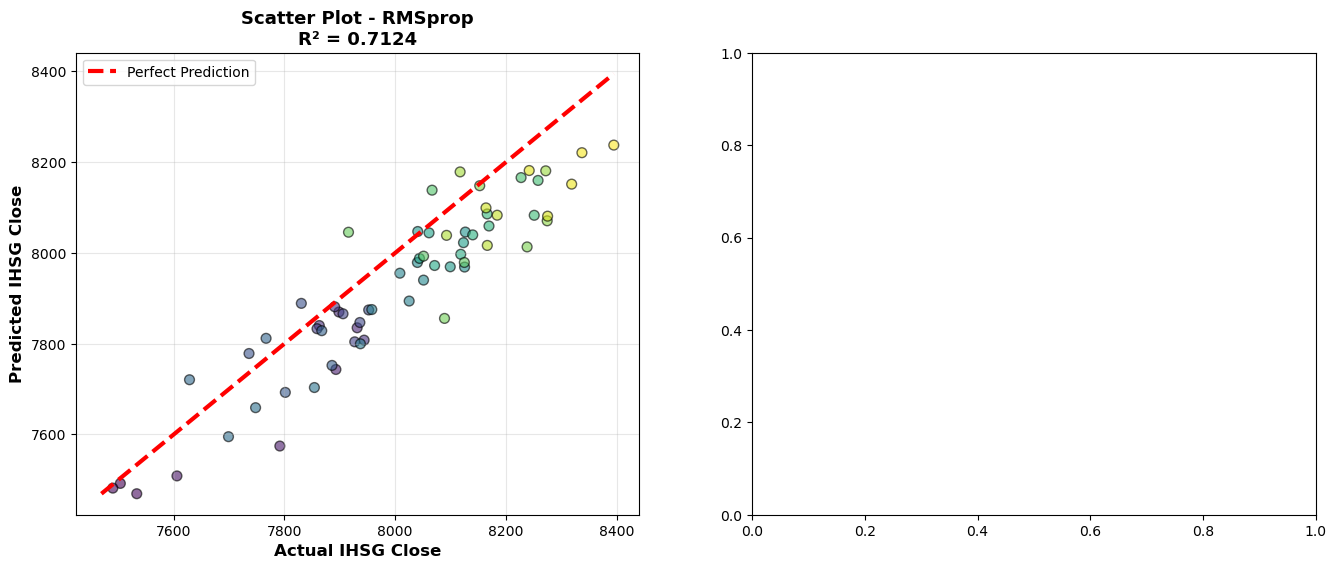

In [12]:
# Visualisasi 4: Scatter Plot Best Optimizer
best_opt = results_df.index[0]
y_pred_best = predictions[best_opt]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_test, y_pred_best, alpha=0.6, s=50, c=range(len(y_test)), cmap='viridis', edgecolors='black')
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Perfect Prediction')
ax1.set_xlabel('Actual IHSG Close', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted IHSG Close', fontsize=12, fontweight='bold')
ax1.set_title(f'Scatter Plot - {best_opt}\nR² = {results[best_opt]["R2"]:.4f}', 
              fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

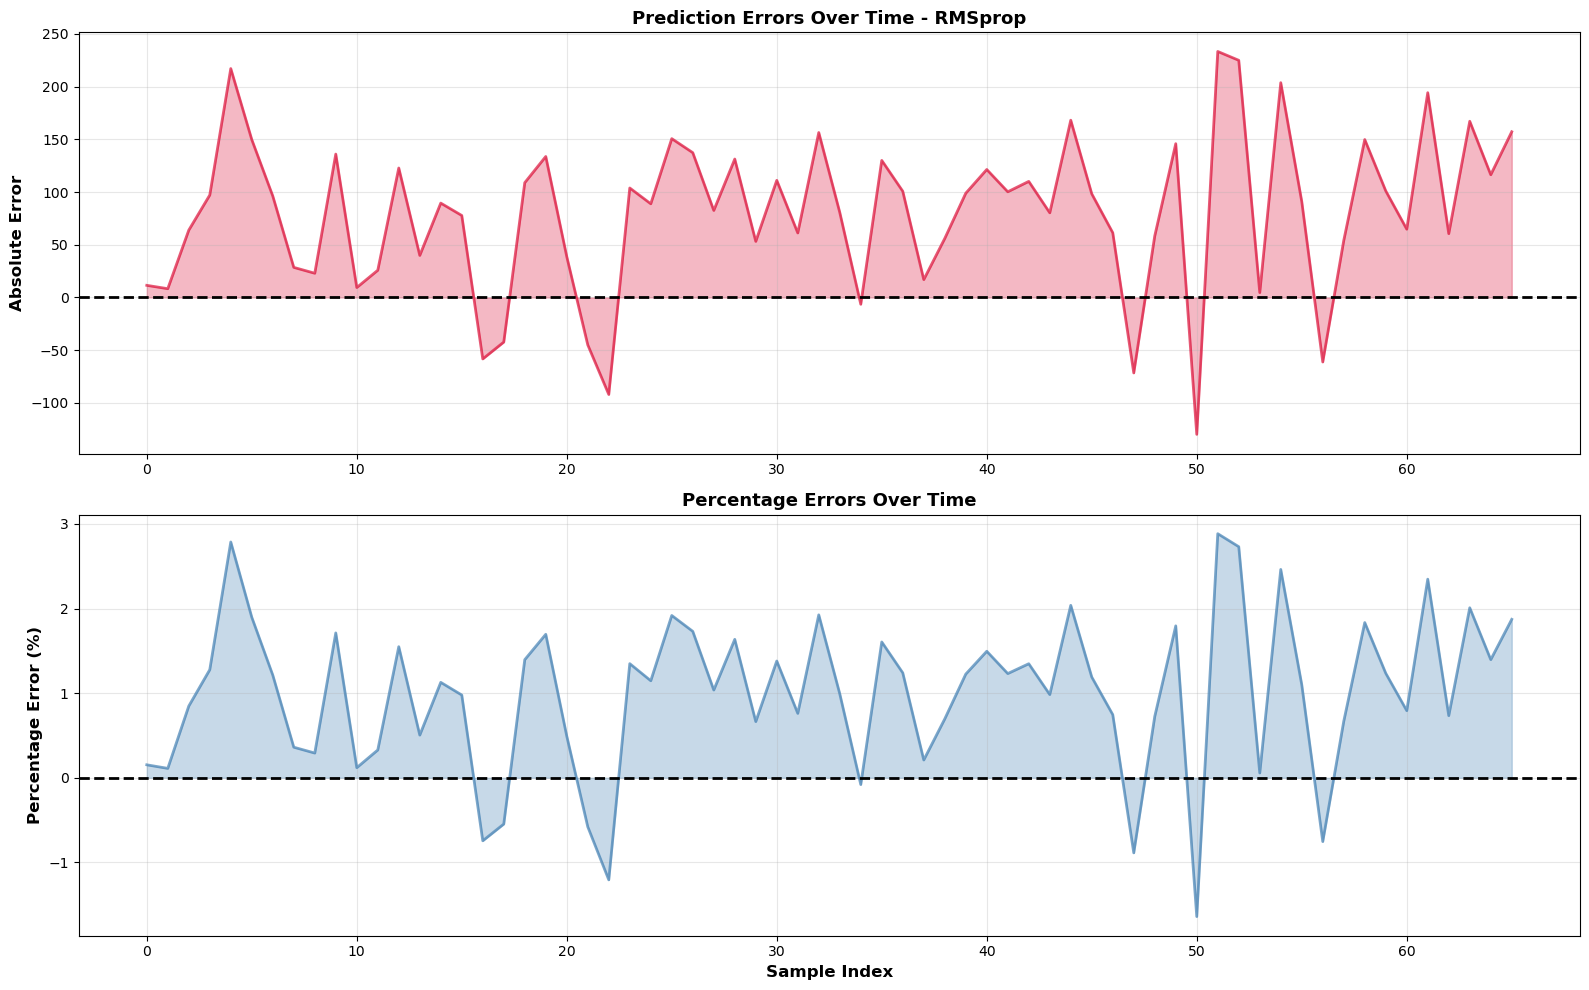

In [13]:
# Visualisasi 5: Error Over Time
errors = y_test - y_pred_best.flatten()
error_pct = (errors / y_test) * 100

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

ax1 = axes[0]
ax1.plot(errors, linewidth=2, color='crimson', alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax1.fill_between(range(len(errors)), 0, errors, alpha=0.3, color='crimson')
ax1.set_ylabel('Absolute Error', fontsize=12, fontweight='bold')
ax1.set_title(f'Prediction Errors Over Time - {best_opt}', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(error_pct, linewidth=2, color='steelblue', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax2.fill_between(range(len(error_pct)), 0, error_pct, alpha=0.3, color='steelblue')
ax2.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage Error (%)', fontsize=12, fontweight='bold')
ax2.set_title('Percentage Errors Over Time', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [14]:
# Summary
print("\n" + "="*80)
print("KESIMPULAN")
print("="*80)
print(f"\n🏆 BEST OPTIMIZER: {best_opt}")
print(f"\n📊 Performance Metrics:")
for metric, value in results[best_opt].items():
    if metric != 'Epochs':
        print(f"   {metric:6s}: {value:8.4f}")
    else:
        print(f"   {metric:6s}: {value}")

print("\n" + "="*80)
print("✅ TRAINING COMPLETED!")
print("="*80)



KESIMPULAN

🏆 BEST OPTIMIZER: RMSprop

📊 Performance Metrics:
   MSE   : 12165.6241
   RMSE  : 110.2979
   MAE   :  95.6245
   R2    :   0.7124
   MAPE  :   1.1890
   Epochs: 68

✅ TRAINING COMPLETED!


## Residual Analysis


Statistik Residual untuk RMSprop:
Mean: 80.271388
Std: 75.644751
Min: -129.831055
Max: 233.319824


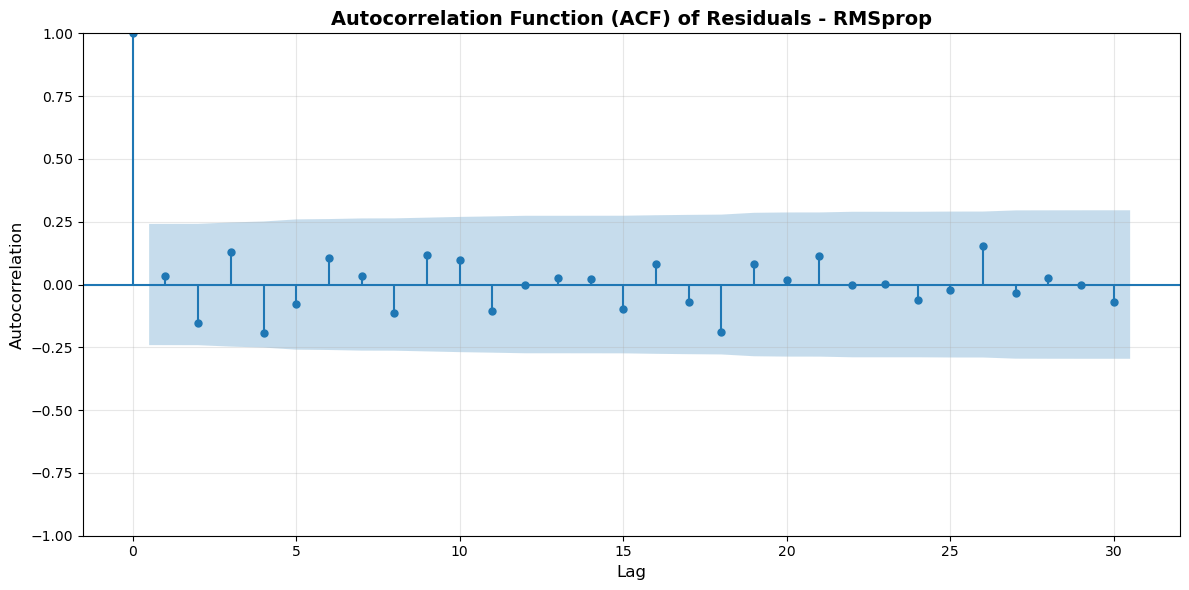

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Hitung residual dari model terbaik
best_opt = results_df.index[0]
y_pred_best = predictions[best_opt]
residuals = y_test - y_pred_best.flatten()

# Plot ACF residual
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(residuals, lags=30, ax=ax, alpha=0.05)  # alpha=0.05 untuk 95% confidence interval
ax.set_title(f'Autocorrelation Function (ACF) of Residuals - {best_opt}', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)
ax.grid(True, alpha=0.3)

# Tambahkan informasi statistik residual
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
print(f"\nStatistik Residual untuk {best_opt}:")
print(f"Mean: {mean_residual:.6f}")
print(f"Std: {std_residual:.6f}")
print(f"Min: {residuals.min():.6f}")
print(f"Max: {residuals.max():.6f}")

plt.tight_layout()
plt.show()